In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


- there were 2 num_cells_vec variables
- also don't know if or why exactly cybersort and augmented data are needed for me

In [2]:
# parameters


#os.chdir('/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/matrix')

aug_data_path = "/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/matrix/results/pseudos"
cybersort_path = "/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/matrix/results/pseudos"
data_path = "/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/matrix"
scpred_path = "/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/metafolder"


#num_cells_vec = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_cells_vec = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


#####################
### set the study ###
#####################

res_name = "pseudobulk_6k"
results_file = f"{data_path}/{res_name}.h5ad"


data results not loading correctly with gene_ids.

In [3]:
# read in the data

os.chdir(data_path)
adata = sc.read_csv('matrix.csv')

#need to read the raw data here 


adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.var['gene_ids'] = adata.var_names

In [4]:
os.chdir('/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/metafolder/')
meta_data = pd.read_csv("metadata.csv", sep="\,")

#oligos
meta_data = meta_data.replace(to_replace=['Oligo L4-6 OPALIN', 'Oligo L4-6 MOBP COL18A1'],value=['Oligodendrocyte', 'Oligodendrocyte'])

#microglia
meta_data = meta_data.replace(to_replace=['Micro L1-6 C1QC'], value=['Microglia'])


#Astrocyes
meta_data = meta_data.replace(to_replace=['Astro L1-6 FGFR3 ETNPPL', 'Astro L1 FGFR3 MT1G','Astro L1 FGFR3 FOS'], value=['Astrocyte', 'Astrocyte', 'Astrocyte'])


#opcs
meta_data = meta_data.replace(to_replace=['OPC L1-6 MYT1'], value= ['OPC'])

#endocytes
meta_data = meta_data.replace(to_replace=['Endo L2-5 CLDN5'], value=['Endocyte'])

#others
meta_data = meta_data.fillna('')
meta_data = meta_data.replace(to_replace=['VLMC L1-3 CYP1B1', 'Peri L1-6 MUSTN1', 'NA', ''], value= ['Other', 'Other', 'Other', 'Other'])


meta_data = meta_data.replace(regex=r'Inh', value= 'Neuron')
meta_data = meta_data.replace(regex=r'Exc', value = 'Neuron')


meta_data = meta_data.replace(regex='Neuron\s\w\w\s\w*\w*', value = 'Neuron')
meta_data = meta_data.replace(regex='Neuron\s\w\w\W\s\w*\w*', value = 'Neuron')



meta_data = meta_data.replace(regex='Neuron\s\w*', value = 'Neuron')


meta_data = meta_data.replace(regex='Neuron\W\w\s\w*', value = 'Neuron')


meta_data = meta_data.replace(regex='Neuron\s\w*', value = 'Neuron')


meta_data['scpred_prediction']= meta_data.cell_type_alias_label


###df["B"] = df["A"].astype('category')   example

meta_data.cell_type_alias_label = meta_data.cell_type_alias_label.astype('category')





/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_1415/658543507.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  meta_data = pd.read_csv("metadata.csv", sep="\,")


checking cell types:

In [5]:
meta_data.cell_type_alias_label

0                  Other
1                 Neuron
2                 Neuron
3                 Neuron
4                 Neuron
              ...       
49412          Astrocyte
49413             Neuron
49414             Neuron
49415    Oligodendrocyte
49416    Oligodendrocyte
Name: cell_type_alias_label, Length: 49417, dtype: category
Categories (7, object): ['Astrocyte', 'Endocyte', 'Microglia', 'Neuron', 'OPC', 'Oligodendrocyte', 'Other']

assigning cell types:

In [6]:
adata.obs['scpred_CellType'] = meta_data.cell_type_alias_label.values

In [7]:
adata.obs

scpred_CellType
F2S4_160113_027_A01            Other
F2S4_160113_027_B01           Neuron
F2S4_160113_027_C01           Neuron
F2S4_160113_027_D01           Neuron
F2S4_160113_027_E01           Neuron
...                              ...
F2S4_190227_100_C01        Astrocyte
F2S4_190227_100_E01           Neuron
F2S4_190227_100_F01           Neuron
F2S4_190227_100_G01  Oligodendrocyte
F2S4_190227_100_H01  Oligodendrocyte

[49417 rows x 1 columns]

I couldn't find an easy way to save the file and open it here, so i am editing it live.

os.chdir('/Users/ivicha/Documents/GreeneLab/NormalCortex_Data/From_brainMap/metafolder/')
meta_data = pd.read_csv("metadata.csv", sep="\,")

#oligos
meta_data = meta_data.replace(to_replace=['Oligo L4-6 OPALIN', 'Oligo L4-6 MOBP COL18A1'],value=['Oligodendrocyte', 'Oligodendrocyte'])

#microglia
meta_data = meta_data.replace(to_replace=['Micro L1-6 C1QC'], value=['Microglia'])


#Astrocyes
meta_data = meta_data.replace(to_replace=['Astro L1-6 FGFR3 ETNPPL', 'Astro L1 FGFR3 MT1G','Astro L1 FGFR3 FOS'], value=['Astrocyte', 'Astrocyte', 'Astrocyte'])


#opcs
meta_data = meta_data.replace(to_replace=['OPC L1-6 MYT1'], value= ['OPC'])

#endocytes
meta_data = meta_data.replace(to_replace=['Endo L2-5 CLDN5'], value=['Endocyte'])

#others
meta_data = meta_data.fillna('')
meta_data = meta_data.replace(to_replace=['VLMC L1-3 CYP1B1', 'Peri L1-6 MUSTN1', 'NA', ''], value= ['Other', 'Other', 'Other', 'Other'])


meta_data = meta_data.replace(regex=r'Inh', value= 'Neuron')
meta_data = meta_data.replace(regex=r'Exc', value = 'Neuron')


meta_data = meta_data.replace(regex='Neuron\s\w\w\s\w*\w*', value = 'Neuron')
meta_data = meta_data.replace(regex='Neuron\s\w\w\W\s\w*\w*', value = 'Neuron')



meta_data = meta_data.replace(regex='Neuron\s\w*', value = 'Neuron')


meta_data = meta_data.replace(regex='Neuron\W\w\s\w*', value = 'Neuron')


meta_data = meta_data.replace(regex='Neuron\s\w*', value = 'Neuron')


meta_data['scpred_prediction']= meta_data.cell_type_alias_label

skipping this one because the length of the metadata doesn't match the edited anndata. the anndata already has the cell type predictions.

In [8]:

# add metadata
#os.chdir(scpred_path)
#results_file_meta = 'results_file_meta.csv'
#meta_data = pd.read_csv(results_file_meta, sep="\,")
#barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
#meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)

#adata.obs['CellType'] = meta_df['cell_type'].tolist()
#adata.obs['scpred_CellType'] = meta_data['scpred_prediction'].tolist()


adding the observation of scpred_CellType to match the rest of the code. anndata already had cell_type as observation:

In [9]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs['scpred_CellType'].values.unique()


In [10]:
cell_type_remove = ["NA"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
adata.obs['scpred_CellType']
print(adata.obs["scpred_CellType"].values.unique())

['Other', 'Neuron', 'Oligodendrocyte', 'Astrocyte', 'OPC', 'Microglia', 'Endocyte']
Categories (7, object): ['Astrocyte', 'Endocyte', 'Microglia', 'Neuron', 'OPC', 'Oligodendrocyte', 'Other']


In [11]:
# group together cell types that are not very frequent

all_vals = adata.obs["scpred_CellType"].to_list()
#all_vals = np.char.replace(all_vals, 'adc', 'other')
#all_vals = np.char.replace(all_vals, 'pdc', 'other')
#all_vals = np.char.replace(all_vals, 'mk', 'other')
#all_vals = np.char.replace(all_vals, 'hsc', 'other')
adata.obs["scpred_CellType"] = all_vals

from collections import Counter

Counter(all_vals)

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_1415/2299051106.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["scpred_CellType"] = all_vals


Counter({'Other': 2028,
         'Neuron': 42679,
         'Oligodendrocyte': 1930,
         'Astrocyte': 1187,
         'OPC': 773,
         'Microglia': 750,
         'Endocyte': 70})

the gene_ids are not defined anywhere.. need to assign the first column of anndata to be geneids

I deleted "todense()" because i cant get any good documentation on it and not sure what it's doing. doesn't recognize it.

not sure what's going on here:

In [12]:
#write out data for BP and cibersort

# nonperturbed means we sample monocytes from mon16
braincells = ["Neurons", "Oligodendrocytes", "OPC", "Microglia", "Astrocytes", "Endocytes", 'Other']
sig_nonperturb = adata[adata.obs["scpred_CellType"].isin(braincells)]

all_vals = sig_nonperturb.obs["scpred_CellType"].to_list()
#all_vals = np.char.replace(all_vals, 'braincells', 'Neurons')  #deleted mono from here and added neurons
sig_nonperturb.obs["scpred_CellType"] = all_vals

dense_matrix = sig_nonperturb.X   #deleted todense() from here too, it doesn't work

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = sig_nonperturb.var['gene_ids'])  
dense_df.insert(loc=0, column='scpred_CellType', value=sig_nonperturb.obs["scpred_CellType"].to_list())

#pickle.dump(dense_df, open( sc_profile_path, "wb" ) )


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_1415/2137659512.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sig_nonperturb.obs["scpred_CellType"] = all_vals


In [13]:
 ###write out data for BP and cibersort

dense_matrix = adata.X

In [14]:
#sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
#sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())

pickle.dump(dense_df, open( sc_profile_path, "wb" ) )

dense_matrix.shape

(49417, 50281)

QCing steps and plotting data:

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


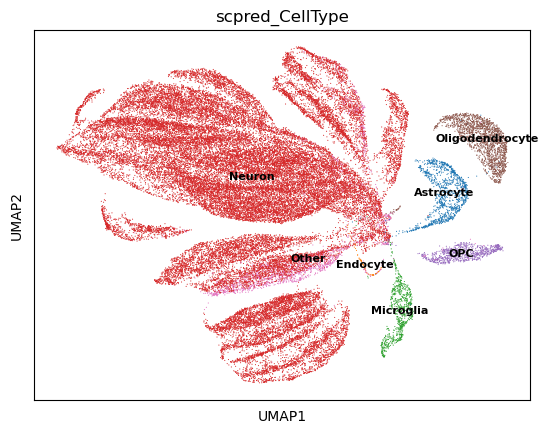

In [15]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)

Pseudobulks:

In [16]:
len_vector = adata.obs["scpred_CellType"].unique().shape[0]


Added the cell perturbations for each cell time 

In [17]:
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# make b-cells be perturbed -- this will be used for unlabeled: also perturbing each cell
cell_noise_perturb = cell_noise
cell_noise_perturb[0] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[1] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[2] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[3] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[4] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[5] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[6] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])


In [18]:
adata.obs["scpred_CellType"].unique().shape[0]
adata.obs["scpred_CellType"]

F2S4_160113_027_A01              Other
F2S4_160113_027_B01             Neuron
F2S4_160113_027_C01             Neuron
F2S4_160113_027_D01             Neuron
F2S4_160113_027_E01             Neuron
                            ...       
F2S4_190227_100_C01          Astrocyte
F2S4_190227_100_E01             Neuron
F2S4_190227_100_F01             Neuron
F2S4_190227_100_G01    Oligodendrocyte
F2S4_190227_100_H01    Oligodendrocyte
Name: scpred_CellType, Length: 49417, dtype: category
Categories (7, object): ['Astrocyte', 'Endocyte', 'Microglia', 'Neuron', 'OPC', 'Oligodendrocyte', 'Other']

In [19]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )



up to here it runs! the following cell does not run.

In [20]:
#now making cell type specific noise:


# simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_pseudo_{idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_prop_{idx}.pkl")
  test_pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_testpseudo_{idx}.pkl")
  test_pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_testprop_{idx}.pkl")

  # if unlabeled data, we need to have both perturbed and non-perturbed cell types
  # idx 0 is for testing and will be perturbed
  # idx 1-4 are not perturbed because they are labeled
  # idx 5 is ignored for now, we will make it perturbed
  # idx 6-9 are unlabeled and will have be perturbed half not be
  # so this makes idx 5,6,7 perturbed
  # idx 8,9 unperturbed
  # summary:
  # perturbed: 0,5,6,7
  # unperturb: 1,2,3,4,8,9
  # train: 1,2,3,4,6,7,8,9
  # test:  0
  # labeled: 1,2,3,4
  # unlabeled: 6,7,8,9

  perturbed_idx = np.array([0,5,6,7])
  cell_noise_choice = cell_noise
  if idx in perturbed_idx:
    cell_noise_choice = cell_noise_perturb

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  test_pseudobulk_path = Path(test_pbmc_rep1_pseudobulk_file)
  test_prop_path = Path(test_pbmc_rep1_prop_file)

  if not pseudobulk_path.is_file(): # skip if we already generated it

    # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(adata, 
                                                                            num_samples, 
                                                                            num_cells,
                                                                            use_true_prop=False,
                                                                            cell_noise=cell_noise_choice)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    test_prop_df = test_prop_df.div(test_prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

    pickle.dump( test_prop_df, open( test_prop_path, "wb" ) )
    pickle.dump( test_pseudobulks_df, open( test_pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
        assert False, "Proportions do not sum to 1"

New Domain 0
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 1
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 2
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 3
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 4
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 5
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 6
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 7
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 8
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu

New Domain 9
0


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

100


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

200


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

300


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

400


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

500


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

600


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

700


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

800


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

900


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_prop = total_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_expr = total_expr.append(sum_over_cells)
/Users/ivi

1000


/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prop = test_prop.append(props)
/Users/ivicha/Documents/VSCode/sc_preprocessing/sc_preprocess.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_expr = test_expr.append(sum_over_cells)
/Users/ivicha/Docu